In [1]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from torch.utils.data import random_split
from sklearn.model_selection import KFold
from torch import nn, optim

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [4]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [5]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_loss(loss_fn, pred, labels_a, labels_b, lam):
    return lam * loss_fn(pred, labels_a) + (1 - lam) * loss_fn(pred, labels_b)

In [6]:
# Import Libraries
import torch
import torch.nn as nn
from torchvision import transforms
from sklearn.utils.class_weight import compute_class_weight

# Define Focal Loss Function
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Define Data Augmentation (for specific classes)
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

default_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [7]:
df = pd.read_csv('/root/CV_PJT/CV_PJT/code/train2.csv')
sample_submission_df = pd.read_csv("/root/CV_PJT/CV_PJT/data/data/sample_submission.csv")

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [8]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'datasets_fin/'

# model config
model_name = 'resnet34'

# training config
img_size = 260
LR = 1e-4
EPOCHS = 100
BATCH_SIZE = 32
num_workers = 0
log_interval = 100

In [9]:
# Focal Loss hyperparameters (if using)
ALPHA = 1
GAMMA = 2

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [10]:
# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [11]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight

# Dataset definition
full_dataset = ImageDataset(
    "/root/CV_PJT/CV_PJT/code/train2.csv",
    "/root/CV_PJT/CV_PJT/data/data/train",
    transform=trn_transform
)

# Calculate the total number of samples in the dataset
dataset_size = len(full_dataset)

# Define the ratios for training and validation
train_ratio = 0.8  # Use 80% of the data for training
val_ratio = 1 - train_ratio  # Remaining 20% for validation

# Calculate the number of samples for training and validation
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size  # Ensure all samples are accounted for

# Split the dataset into training and validation sets
trn_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Calculate class weights based on training data labels (for CrossEntropyLoss with class weights)
train_labels = [label for _, label in trn_dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use WeightedRandomSampler for oversampling in training set (optional)
class_sample_count = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])
weights = 1. / class_sample_count
samples_weights = np.array([weights[t] for t in train_labels])
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

# DataLoader with sampler for oversampling (if needed)
train_loader = DataLoader(trn_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Define the test dataset
tst_dataset = ImageDataset(
    "/root/CV_PJT/CV_PJT/data/data/sample_submission.csv",
    "/root/CV_PJT/CV_PJT/data/data/test",
    transform=tst_transform
)

# Print the sizes of the datasets
print("Training dataset size:", len(trn_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(tst_dataset))

Training dataset size: 118387
Validation dataset size: 29597
Test dataset size: 3140


In [12]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [13]:
def validate(loader, model, loss_fn, device):
    model.eval()
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():
        for image, targets in loader:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)
            loss = loss_fn(preds, targets)
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())
    
    val_loss /= len(loader)
    val_acc = accuracy_score(targets_list, preds_list)
    val_f1 = f1_score(targets_list, preds_list, average='macro')
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

In [ ]:
# Dataset & K-Fold Configuration
dataset = trn_dataset
k_folds = 3
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Placeholder for Results
fold_results = []

# K-Fold Cross-Validation Process
for fold, (train_ids, valid_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Data Loaders for Train and Validation
    train_subsampler = Subset(dataset, train_ids)
    valid_subsampler = Subset(dataset, valid_ids)
    train_loader = DataLoader(train_subsampler, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
    valid_loader = DataLoader(valid_subsampler, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

    # Model, Loss, Optimizer Initialization
    model = timm.create_model('resnet34', pretrained=True, num_classes=17).to(device)
    # loss_fn = nn.CrossEntropyLoss()
    # Option 2: Use Focal Loss instead of CrossEntropyLoss (if needed)
    loss_fn = FocalLoss(alpha=ALPHA, gamma=GAMMA)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Initialize Early Stopping
    early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.001,
                                   path=f'/root/CV_PJT/CV_PJT/code/fold3/resnet34_fold_{fold}_checkpoint.pt')

    # Performance Tracking for Each Fold
    fold_performance = {
        'train_acc': [],
        'train_f1': [],
        'val_acc': [],
        'val_f1': []
    }

    # Training Loop with Early Stopping
    for epoch in range(EPOCHS):
        # Training Phase
        train_results = train_one_epoch(train_loader, model, optimizer, loss_fn, device)
        fold_performance['train_acc'].append(train_results['train_acc'])
        fold_performance['train_f1'].append(train_results['train_f1'])

        # Validation Phase
        val_results = validate(valid_loader, model, loss_fn, device)
        fold_performance['val_acc'].append(val_results['val_acc'])
        fold_performance['val_f1'].append(val_results['val_f1'])

        # Early Stopping Check
        early_stopping(val_results['val_loss'], model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load Best Model for This Fold
    model.load_state_dict(torch.load(f'/root/CV_PJT/CV_PJT/code/fold3/resnet34_fold_{fold}_checkpoint.pt'))

    # Store Results for This Fold
    fold_results.append(fold_performance)
    print(f'Fold {fold} completed. Best val accuracy: {val_results["val_acc"]}, Best val F1 Score: {val_results["val_f1"]}\n')

# Average Performance Across Folds
train_accs = [np.mean(fold['train_acc']) for fold in fold_results]
train_f1s = [np.mean(fold['train_f1']) for fold in fold_results]
val_accs = [np.mean(fold['val_acc']) for fold in fold_results]
val_f1s = [np.mean(fold['val_f1']) for fold in fold_results]

print(f'Average Train Accuracy: {np.mean(train_accs)}, Average Train F1 Score: {np.mean(train_f1s)}')
print(f'Average Validation Accuracy: {np.mean(val_accs)}, Average Validation F1 Score: {np.mean(val_f1s)}')

FOLD 0
--------------------------------


Loss: 0.0099: 100%|██████████| 2467/2467 [04:55<00:00,  8.34it/s]


Validation loss decreased (inf --> 0.018164). Saving model...


Loss: 0.0492: 100%|██████████| 2467/2467 [04:53<00:00,  8.39it/s]


Validation loss decreased (0.018164 --> 0.004674). Saving model...


Loss: 0.0032: 100%|██████████| 2467/2467 [04:55<00:00,  8.35it/s]


Validation loss decreased (0.004674 --> 0.002492). Saving model...


Loss: 0.0111: 100%|██████████| 2467/2467 [04:55<00:00,  8.35it/s]


Validation loss decreased (0.002492 --> 0.001375). Saving model...


Loss: 0.0003: 100%|██████████| 2467/2467 [04:55<00:00,  8.34it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0002: 100%|██████████| 2467/2467 [04:54<00:00,  8.37it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.0002: 100%|██████████| 2467/2467 [04:55<00:00,  8.36it/s]


EarlyStopping counter: 3 out of 5


Loss: 0.0005: 100%|██████████| 2467/2467 [04:55<00:00,  8.35it/s]


EarlyStopping counter: 4 out of 5


Loss: 0.0000: 100%|██████████| 2467/2467 [04:55<00:00,  8.34it/s]


EarlyStopping counter: 5 out of 5
Early stopping
Fold 0 completed. Best val accuracy: 0.9841877201429187, Best val F1 Score: 0.9843874880684623

FOLD 1
--------------------------------


Loss: 0.2275: 100%|██████████| 2467/2467 [04:56<00:00,  8.33it/s]


Validation loss decreased (inf --> 0.014381). Saving model...


Loss: 0.0003: 100%|██████████| 2467/2467 [04:54<00:00,  8.37it/s]


Validation loss decreased (0.014381 --> 0.004218). Saving model...


Loss: 0.0010: 100%|██████████| 2467/2467 [04:55<00:00,  8.34it/s]


Validation loss decreased (0.004218 --> 0.002152). Saving model...


Loss: 0.0012: 100%|██████████| 2467/2467 [04:55<00:00,  8.34it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0009: 100%|██████████| 2467/2467 [04:55<00:00,  8.34it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.0000: 100%|██████████| 2467/2467 [04:55<00:00,  8.34it/s]


Validation loss decreased (0.002152 --> 0.000810). Saving model...


Loss: 0.0229: 100%|██████████| 2467/2467 [04:57<00:00,  8.30it/s]


EarlyStopping counter: 1 out of 5


Loss: 0.0078: 100%|██████████| 2467/2467 [04:57<00:00,  8.30it/s]


EarlyStopping counter: 2 out of 5


Loss: 0.0000: 100%|██████████| 2467/2467 [04:56<00:00,  8.32it/s]


EarlyStopping counter: 3 out of 5


Loss: 0.0002: 100%|██████████| 2467/2467 [04:56<00:00,  8.32it/s]


EarlyStopping counter: 4 out of 5


Loss: 0.0000: 100%|██████████| 2467/2467 [04:57<00:00,  8.29it/s]


KeyboardInterrupt: 

In [20]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

'# load model\nmodel = timm.create_model(\n    model_name,\n    pretrained=True,\n    num_classes=17\n).to(device)\nloss_fn = nn.CrossEntropyLoss()\noptimizer = Adam(model.parameters(), lr=LR)'

In [21]:
for epoch in range(EPOCHS):
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    ret['epoch'] = epoch

    log = ""
    for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
    print(log)

'for epoch in range(EPOCHS):\n    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)\n    ret[\'epoch\'] = epoch\n\n    log = ""\n    for k, v in ret.items():\n      log += f"{k}: {v:.4f}\n"\n    print(log)'

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [16]:
import numpy as np
from scipy.stats import mode
from tqdm.auto import tqdm

# 테스트 데이터셋에 대한 각 폴드의 모델 예측 수행
k_folds = 2

predictions = []
for fold in range(k_folds):
    # 각 폴드의 모델을 로드합니다.
    model.load_state_dict(torch.load(f'/root/CV_PJT/CV_PJT/code/fold3/resnet34_fold_{fold}_checkpoint.pt'))
    model.eval()
    fold_predictions = []
    with torch.no_grad():
        for images, _ in tqdm(tst_loader, desc=f'Predicting with fold {fold}'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            fold_predictions.extend(predicted.cpu().numpy())
    predictions.append(fold_predictions)

# 앙상블 예측: 다수결 보팅
predictions = np.array(predictions)
predictions = np.transpose(predictions, (1, 0))

preds_list = []
for i in range(len(predictions)):
    mode_result = mode(predictions[i])
    preds_list.append(mode_result[0])
    
len(preds_list)

Predicting with fold 0:   0%|          | 0/99 [00:00<?, ?it/s]

Predicting with fold 1:   0%|          | 0/99 [00:00<?, ?it/s]

3140

In [17]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [18]:
sample_submission_df = pd.read_csv("/root/CV_PJT/CV_PJT/data/data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [19]:
pred_df.to_csv("pred_12.csv", index=False)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_192127/3309000382.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=pred_df, palette='Set2')


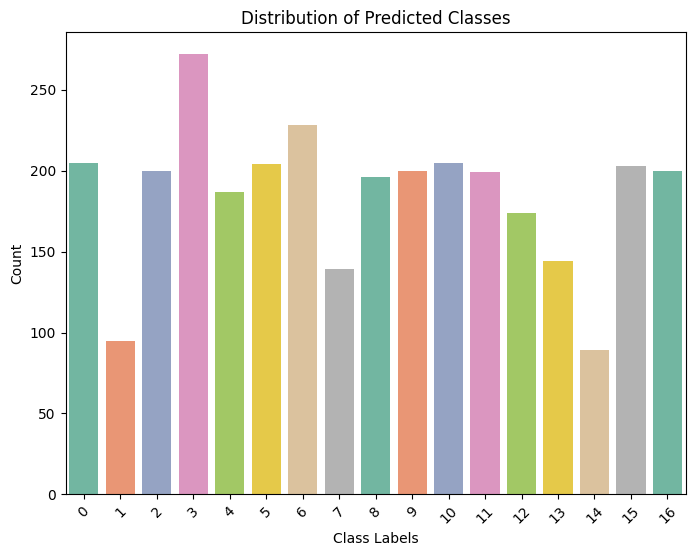

In [21]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Count the number of predictions per class
sns.countplot(x='target', data=pred_df, palette='Set2')
plt.title('Distribution of Predicted Classes')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [1]:
import pandas as pd

In [3]:
pred_df = pd.read_csv('/root/CV_PJT/CV_PJT/code/pred_12.csv')

In [ ]:
# Visualizing Misclassified Images
num_images = min(len(misclassified_images), 16)  # Display up to 16 images
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(4, 4, i + 1)  # 4x4 grid for images
    plt.imshow(misclassified_images[i].permute(1, 2, 0))  # Change channel order for plotting
    plt.title(f'True: {misclassified_labels[i]}, Predicted: {misclassified_preds[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Now, assuming you have a list of test image filenames:
test_image_filenames = [...]  # Load or define your test image filenames here

# Displaying the actual test images corresponding to the misclassified images
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(4, 4, i + 1)  # 4x4 grid for images
    test_image_index = misclassified_indices[i]  # Index of the misclassified image in the valid set
    plt.imshow(misclassified_images[i].permute(1, 2, 0))  # Display the misclassified image
    plt.title(f'File: {test_image_filenames[test_image_index]}')  # Show corresponding test filename
    plt.axis('off')
plt.tight_layout()
plt.show()